# 신뢰구간을 활용한 예측에 사용되는 데이터 필터링

## 문제점

수집된 비콘 메시지의 평균 시간 간격은 0.15ms이다. 하지만 실제 데이터의 분포를 출력해보면 평균값과 차이가 큰 이상치가 많은 것을 확인할 수 있다. 이러한 이상치는 다음 시간 간격 값을 정밀히 예측하는데 문제를 발생시키고, 더 나아가 스푸핑 공격을 감지하는데 큰 영향을 미칠 수 있다.

In [1]:
def calc_INT(time):
    INT = np.array([])
    
    for i in range(1, len(time)):
        INT = np.append(INT, df_time[i] - df_time[i-1])
    
    return INT

In [2]:
import pandas as pd
import numpy as np
import time
from statsmodels.tsa.api import Holt
import warnings
warnings.filterwarnings(action='ignore')

df = pd.read_csv('./data/gal_data1.csv')
df_time = df['time']

INT = calc_INT(df_time)
INT_p = INT[21:]
print('Average INT: ', np.mean(INT))

Average INT:  0.15392834037453026


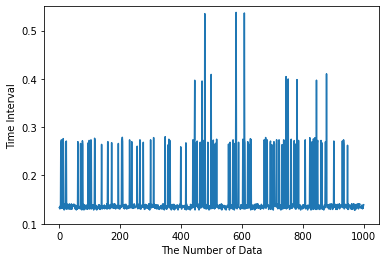

In [3]:
import matplotlib.pyplot as plt

plt.plot(INT)
plt.xlabel('The Number of Data')
plt.ylabel('Time Interval')
plt.ylim(0.1, 0.55)
plt.show()

In [4]:
def percentile(l, s, size):
    if l < s:
        return ( l / s ) / size
    else:
        return ( s / l ) / size

In [5]:
HM = np.array([])

for i in range(20, len(INT)):
    fit = Holt(INT[:i], exponential=True, initialization_method="estimated").fit()
    HM = np.append(HM, fit.forecast(1)[0])

HM_p = np.array([])

for i in range(0, len(INT_p)): 
    HM_p = np.append(HM_p, percentile(INT_p[i], HM[i], len(INT_p)))     

print('Accuracy: ', np.sum(HM_p))

Accuracy:  0.8409678176123869


## 신뢰구간 활용

신뢰구간을 활용하여 예측에 사용되는 시간 간격 데이터를 필터링한다. 신뢰구간으로 필터링 된 데이터는 다음 시간 간격을 예측하는데 사용된다. 위 신뢰구간을 적용하지 않은 그림과 비교했을 때, 이상치가 크게 줄어든 것을 확인할 수 있다. 그리고 다음 시간 간격 값의 예측 정확도 또한 84%에서 99%로 크게 상승하였다.

In [6]:
class Confidence():
    def __init__(self, z):
        self.z = z  # 2.58

    def confidenceInterval(self, use_INT_arr):
        return np.mean(use_INT_arr) + ( self.z * (np.std(use_INT_arr) / np.sqrt(len(use_INT_arr))) )

In [7]:
def calc_INT(time):
    INT = np.array([])
    INT_p = np.array([])
    confi = Confidence(z = 2.58)
    
    for i in range(1, len(time)):
        INT_c = df_time[i] - df_time[i-1]
        
        if len(INT) < 3:
             INT = np.append(INT, INT_c)
             continue
        
        if INT_c < confi.confidenceInterval(INT):
            INT = np.append(INT, INT_c)
            
            if len(INT) > 20:
                INT_p = np.append(INT_p, INT_c)
            
    
    return INT, INT_p

In [8]:
df = pd.read_csv('./data/gal_data1.csv')
df_time = df['time']

INT, INT_p = calc_INT(df_time)
print('Average INT: ', np.mean(INT))

Average INT:  0.1300412954482357


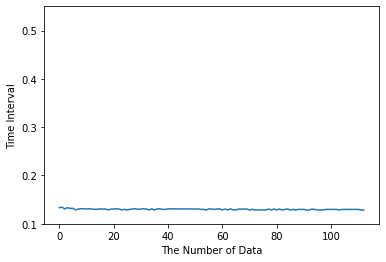

In [9]:
plt.plot(INT)
plt.xlabel('The Number of Data')
plt.ylabel('Time Interval')
plt.ylim(0.1, 0.55)
plt.show()

In [10]:
HM = np.array([])

for i in range(20, len(INT)):
    fit = Holt(INT[:i], exponential=True, initialization_method="estimated").fit()
    HM = np.append(HM, fit.forecast(1)[0])

HM_p = np.array([])

for i in range(0, len(INT_p)): 
    HM_p = np.append(HM_p, percentile(INT_p[i], HM[i], len(INT_p)))     

print('Accuracy: ', np.sum(HM_p))

Accuracy:  0.9944729202934315
